In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from jax import pmap
import pickle as pk

import sys
sys.path.append('/home/amawi/projects/nn_ansatz/src')

import jax
import jax.random as rnd
import jax.numpy as jnp
from jax import vmap, jit, grad, pmap
from jax.experimental.optimizers import adam
from jax import tree_util
from tqdm.notebook import trange

from functools import partial

from nn_ansatz import *
from nn_ansatz.vmc import *

pe = pmap(vmap(partial(compute_potential_energy_solid_i, decompose=True), \
    in_axes=(0, None, None, None, None, None, None, None, None, None)), \
        in_axes=(0, None, None, None, None, None, None, None, None, None))

pe_v2 = pmap(vmap(partial(compute_potential_energy_solid_i_v2, decompose=True), \
    in_axes=(0, None, None, None, None, None, None, None, None, None)), \
        in_axes=(0, None, None, None, None, None, None, None, None, None))

@jit
def compute_rl_factor(volume, kappa, reciprocal_lattice):
    rl_inner_product = inner(reciprocal_lattice, reciprocal_lattice)
    rl_factor = (4*jnp.pi / volume) * jnp.exp(- rl_inner_product / (4*kappa**2)) / rl_inner_product
    return rl_factor

def compute_reciprocal_basis(real_basis, volume):
    cv1, cv2, cv3 = real_basis.split(3, axis=0)
    rv1 = np.cross(cv2.squeeze(), cv3.squeeze()) / volume
    rv2 = np.cross(cv3.squeeze(), cv1.squeeze()) / volume
    rv3 = np.cross(cv1.squeeze(), cv2.squeeze()) / volume
    reciprocal_basis = np.concatenate([x[None, :] for x in (rv1, rv2, rv3)], axis=0)
    return reciprocal_basis * 2 * np.pi

def compute_volume(basis):
    v1, v2, v3 = basis.split(3, axis=0)
    cross = jnp.cross(v2, v3, axisa=1, axisb=1)
    box = jnp.sum(v1 * cross)
    return jnp.abs(jnp.squeeze(box))


In [10]:
kappas = np.linspace(0.25, 2.25, 8)
real_cuts = np.arange(1, 8)
reciprocal_cuts = np.arange(1, 8)

n_el = 6
length = 6.63
volume = length**3
z_atoms = jnp.array([3., 3.])
e_charges = jnp.array([-1. for _ in range(n_el)])
charges = jnp.concatenate([z_atoms, e_charges], axis=0)  # (n_particle, )
q_q = charges[None, :] * charges[:, None]  # q_i * q_j  (n_particle, n_particle)
real_basis = jnp.array([[1., 0., 0.], [0., 1., 0.], [0., 0., 1.]]) * length
reciprocal_basis = compute_reciprocal_basis(real_basis, volume)
r_atoms = jnp.array([[0.0, 0.0, 0.0], [0.5, 0.5, 0.5]]) * length
walkers = jnp.array(np.random.uniform(0, 1, size=(1, 1, 6, 3))) * length

# n_el = 3
# length = 6.63
# volume = length**3
# z_atoms = jnp.array([3.])
# e_charges = jnp.array([-1. for i in range(n_el)])
# charges = jnp.concatenate([z_atoms, e_charges], axis=0)  # (n_particle, )
# q_q = charges[None, :] * charges[:, None]  # q_i * q_j  (n_particle, n_particle)
# real_basis = jnp.array([[1., 0., 0.], [0., 1., 0.], [0., 0., 1.]]) * length
# reciprocal_basis = compute_reciprocal_basis(real_basis, volume)
# r_atoms = jnp.array([[0.5, 0.5, 0.5]]) * length
# walkers = jnp.array(np.random.uniform(0., 1., size=(1, 100, n_el, 3))) * length

volume_test = compute_volume(real_basis)
print('volumes: ', volume, volume_test)



volumes:  291.43424699999997 291.43427


In [11]:
real_lattices = {}
reciprocal_lattices = {}
for i in range(1, 9):
    real_lattices[i] = fast_generate_lattice(real_basis, i)
    reciprocal_lattices[i] = fast_generate_lattice(reciprocal_basis, i)

In [12]:
energies = []
for kappa in kappas:
    for real_cut in real_cuts:
        # real_lattice = fast_generate_lattice(real_basis, real_cut)
        real_lattice = real_lattices[real_cut]
        for reciprocal_cut in reciprocal_cuts:
            # reciprocal_lattice = fast_generate_lattice(reciprocal_basis, reciprocal_cut)
            reciprocal_lattice = reciprocal_lattices[reciprocal_cut]

            rl_factor = compute_rl_factor(volume, kappa, reciprocal_lattice)

            potential, real, reciprocal, constant, self_interaction = \
                pe_v2(walkers, r_atoms, z_atoms, kappa, real_lattice, reciprocal_lattice, q_q, charges, volume, rl_factor)

            results = [kappa, real_cut, reciprocal_cut, 
                       float(real.mean()), float(reciprocal.mean()), float(potential.mean()), 
                       float(constant.mean()), float(self_interaction.mean())]
            energies.append(results)


data = pd.DataFrame(energies, columns=['kappa', 'real_cut', 'reciprocal_cut', 'real', 'reciprocal', 'potential', 'constant', 'self_interaction'])
print(data)

     kappa  real_cut  reciprocal_cut      real  reciprocal  potential  \
0     0.25         1               1 -5.080854    0.030066  -8.435925   
1     0.25         1               2 -5.080854    0.030067  -8.435925   
2     0.25         1               3 -5.080854    0.030067  -8.435925   
3     0.25         1               4 -5.080854    0.030067  -8.435925   
4     0.25         1               5 -5.080854    0.030067  -8.435925   
..     ...       ...             ...       ...         ...        ...   
387   2.25         7               3 -0.027492   15.618891 -14.874835   
388   2.25         7               4 -0.027492   18.720280 -11.773447   
389   2.25         7               5 -0.027492   20.422470 -10.071257   
390   2.25         7               6 -0.027492   21.342539  -9.151188   
391   2.25         7               7 -0.027492   21.761534  -8.732193   

     constant  self_interaction  
0        -0.0         -3.385137  
1        -0.0         -3.385137  
2        -0.0        

kappa:  0.25


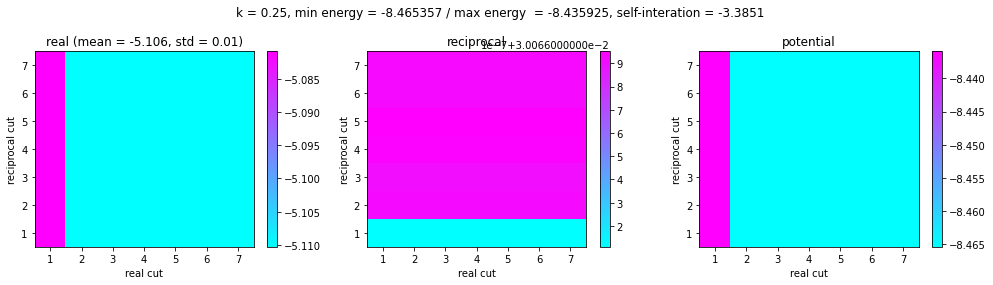

kappa:  0.5357142857142857


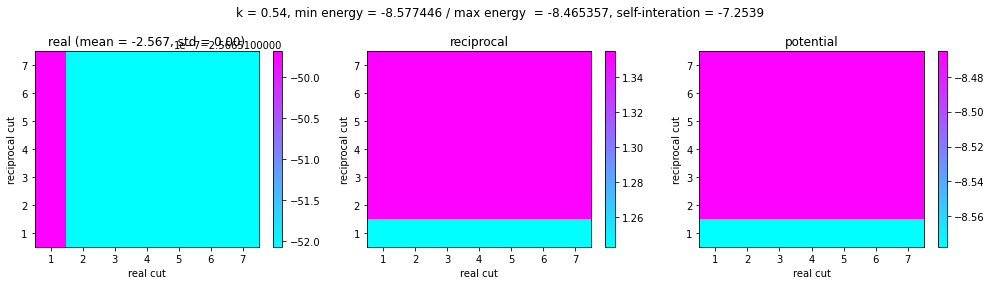

kappa:  0.8214285714285714


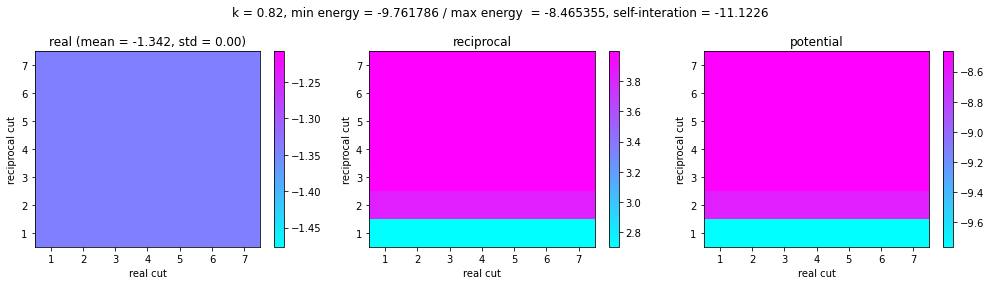

kappa:  1.1071428571428572


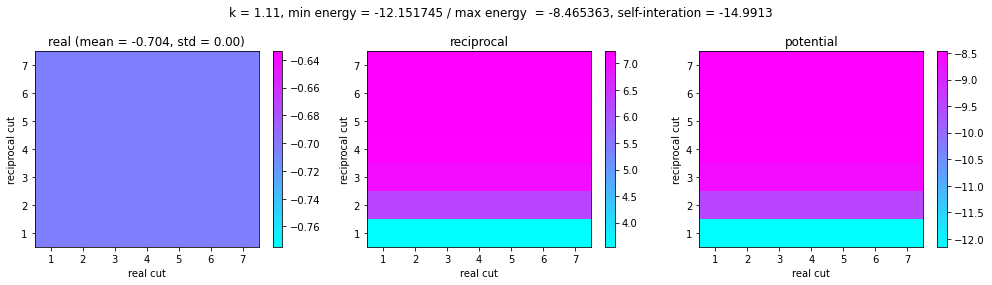

kappa:  1.3928571428571428


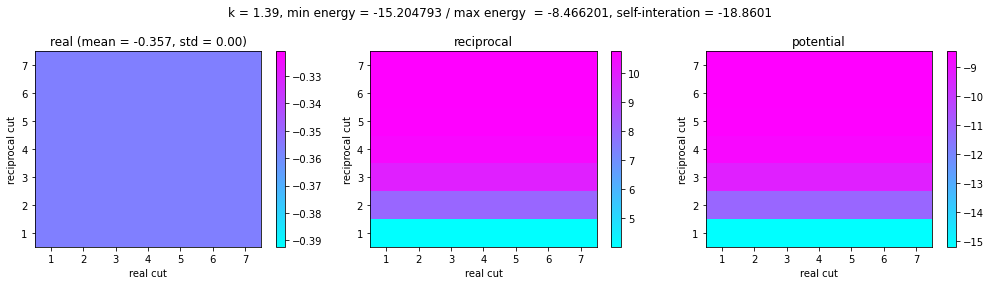

kappa:  1.6785714285714284


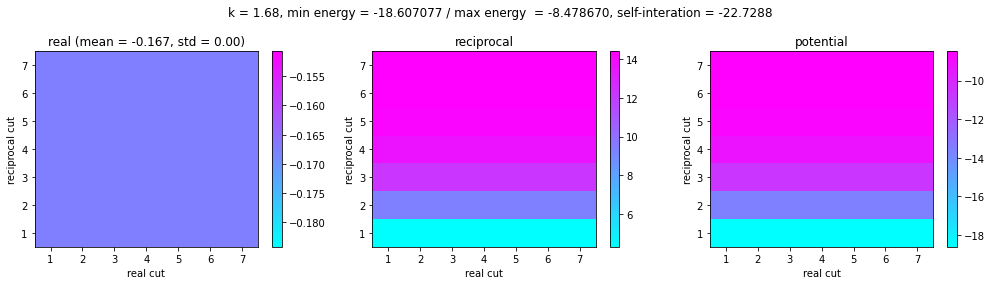

kappa:  1.9642857142857142


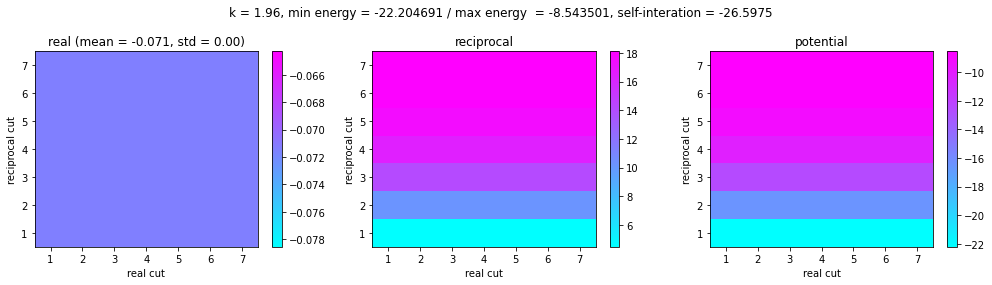

kappa:  2.25


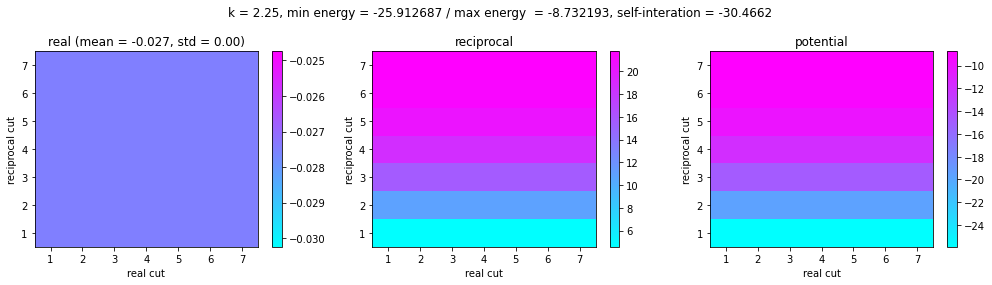

In [13]:
X, Y = np.meshgrid(real_cuts, reciprocal_cuts)

for kappa in kappas:
    print('kappa: ', kappa)
    fig, axs = plt.subplots(1, 3, figsize=(14, 4))
    
    for z, ax in zip(['real', 'reciprocal', 'potential'], axs):
        plot_data = data[data.kappa == kappa].pivot(index='reciprocal_cut', columns='real_cut', values=z)
        p = ax.pcolor(X, Y, plot_data.values, cmap=cm.cool, vmin=plot_data.min().min(), vmax=plot_data.max().max(), shading='auto')
        ax.set_xlabel('real cut')
        ax.set_ylabel('reciprocal cut')
        if z == 'real': z = 'real (mean = %.3f, std = %.2f)' % (np.mean(plot_data.values), np.std(plot_data.values))
        ax.set_title(z)
        cb = fig.colorbar(p, ax=ax)
    fig.suptitle('k = %.2f, min energy = %.6f / max energy  = %.6f, self-interation = %.4f'
                    % (kappa, plot_data.min().min(), plot_data.max().max(), data[data.kappa == kappa]['self_interaction'].mean()))
    fig.tight_layout()
        
    plt.show()